# Data Analysis in R

In [13]:
# Imports
suppressMessages(library(tidyverse))
suppressMessages(library(plyr))
suppressMessages(library(gridExtra))
suppressMessages(library(grid))
suppressMessages(library(scales))

# Load data
frData <- read.csv('../Data/CRat_prepped.csv', stringsAsFactors = FALSE)
frModStats <- read.csv('../Data/ModelStats3.csv', stringsAsFactors = FALSE)

# Extract model information
model_count <- (length(frModStats)-6)/2 # assumes only other cols besides ID are aic/bic/rsqd vals and 5 coefficients (holl2 and 3)
ord <- c('Cubic', 'HollingI', 'HollingII', 'GFR')
model_names <- substr(names(frModStats[2:(1+model_count)]), 1, nchar(names(frModStats[2:(1+model_count)]))-4) #Assumes full model names precede the last 3 chars of header
model_names <- model_names[order(match(model_names, ord))] # Order

## Plotting all fits

In [517]:
## Functions ##
holling2 <- function(R, a, h){
  num <- a*R
  denom <- 1+a*h*R
  return(num/denom)
}

holling3 <- function(R, a, h){
  num <- a*R^2
  denom <- 1+a*h*R^2
  return(num/denom)
}

In [505]:
ids <- unique(frModStats$ID)

## Plot ##
pdf('../Results/FITTING.pdf')
for (id in ids){
  try({
  df <- subset(frData, ID == id)
  stats <- subset(frModStats, ID == id)
  
  # x and y data
  ResDensity <- df$ResDensity
  N_TraitValue <- df$N_TraitValue
  
  ##### MODELS #####
  Cube <- lm(N_TraitValue ~ poly(ResDensity, 3))
  
  # Set x axis
  x <- seq(from = min(ResDensity), to = max(ResDensity), by = ((max(ResDensity) - min(ResDensity))/100))
  
  # Set predicted (y) values according to HollingII
  y_cube <- predict.lm(Cube, data.frame(ResDensity = x))
  y_holl1 <- stats$a_Holl1 * x
  y_holl2 <- holling2(x, stats$a_Holl2, stats$h_Holl2)
  y_holl3 <- holling3(x, stats$a_Holl3, stats$h_Holl3)
      
  # Create dataframe of data to plot (x and y axes)
  data_to_fit <- data.frame(x = x, y_cube = y_cube, y_holl1 = y_holl1, y_holl2 = y_holl2, y_holl3 = y_holl3)
  
  # Plot
  plot(ResDensity, N_TraitValue, main = sprintf("ID: %s", id))
  lines(x, y_cube, col = 3, lwd = 2.5)
  lines(x, y_holl1, col = 6, lwd = 2.5)
  lines(x, y_holl2, col = 2, lwd = 2.5)
  lines(x, y_holl3, col = 4, lwd = 2.5)
  legend("bottomright", legend = c("Cubic", "Holling I", "Holling II", "Holling III"), lwd=2, lty=1, col=c(3,6,2,4))
  }, silent = TRUE)
}
dev.off()

pdf 
  2

In [3]:
plotFits <- function(id){
    df <- subset(frData, ID == id)
    stats <- subset(frModStats, ID == id)
    
    try({
    id <- unique(df$ID)

    x <- df$ResDensity
    y <- df$N_TraitValue
    x_units <- unique(df$ResDensityUnit)
    y_units <- unique(df$TraitUnit)

    # Fit models
    #Quad <- lm(y ~ poly(x, 2))
    Cube <- lm(y ~ poly(x, 3))

    # Generate a vector of the the x-axis variable
    xvals <- seq(from = min(x), to = max(x), by = ((max(x) - min(x))/100))

    # Calculate predicted lines and write points to dataframe
    y_cube <- predict.lm(Cube, data.frame(ResDensity = x))
    y_holl1 <- stats$a_Holl1 * x
    y_holl2 <- holling2(x, stats$a_Holl2, stats$h_Holl2)
    y_holl3 <- holling3(x, stats$a_Holl3, stats$h_Holl3)
    
    data_to_fit <- data.frame(x = x, y_cube = y_cube, y_holl1 = y_holl1, y_holl2 = y_holl2, y_holl3 = y_holl3)

    # Plot
    p <- ggplot(aes(x = ResDensity, y = N_TraitValue), data = df) +
        geom_point() + theme_bw() +
        ggtitle(paste("ID:", id)) +
        theme(legend.position = 'bottom') +
        xlab(sprintf("Resource Density (%s)", x_units)) +
        ylab(sprintf("Trait Value (%s)", y_units)) +
        geom_line(aes(x = x, y = y_cube, colour = "Cubic"), data = data_to_fit) +
        geom_line(aes(x = x, y = y_hol1, colour = "HollingI"), data = data_to_fit) + 
        geom_line(aes(x = x, y = y_hol2, colour = "HollingII"), data = data_to_fit) +
        geom_line(aes(x = x, y = y_hol3, colour = "HollingIII"), data = data_to_fit) #+
        #scale_colour_manual("", breaks = c("Quadratic", "Cubic"), values = c("red", "blue"))

    return(p)
  }, silent = TRUE)
}

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'y_hol1' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(c

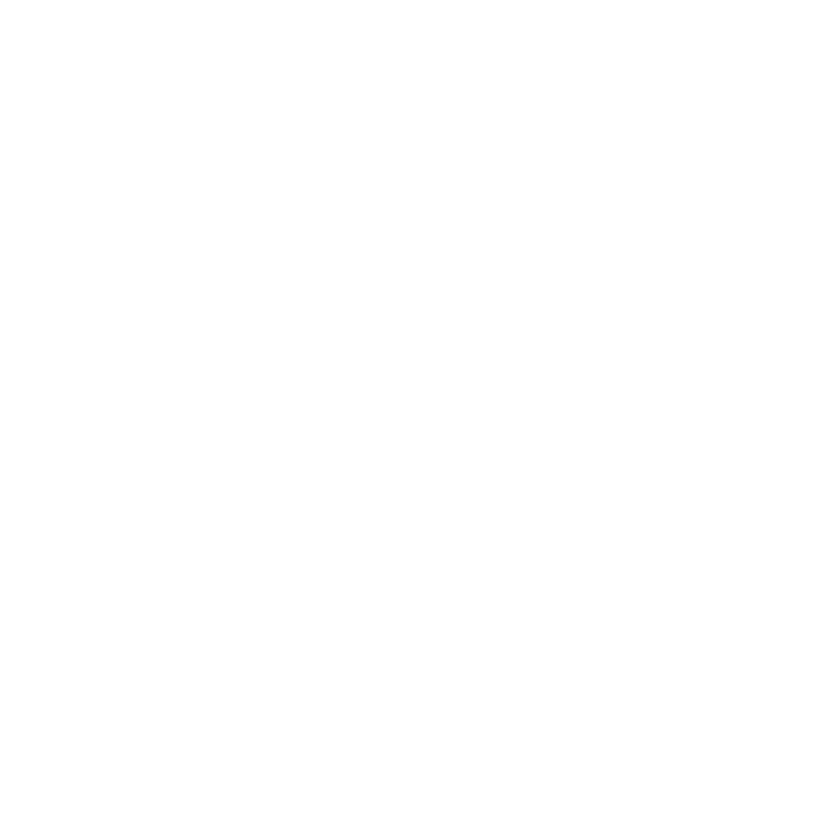

In [4]:
ids1 <- c(39896, 39894, 39877, 39899, 39904)
plotFits(39896)

## Set up the data

In [7]:
# Function for comparing model fits for each ID by both AIC and BIC.
compareModels <- function(row){
  id <- as.character(row[1])
  # Works for comparisons for any number of models
  #model_count <- (length(row)-6)/2 # assumes only other cols besides ID are aic/bic vals
  AICs <- sort(row[2:(1+model_count)])
  BICs <- sort(row[(2+model_count):(1+2*model_count)]) # or just until length(row) if no other cols are added
  
  # Extract model names (assumes the only charcters following the model names are 
  # 'AIC' or 'BIC' - as such only clips last 3)
  mod_names <- substr(names(AICs), 1, nchar(names(AICs))-4)
  
  ##################### Find best fit ###########################
  # Initialise best fit charcter vectors (can't preallocate as final length unknown)
  best_fits_aic <- c(AICs[1])
  best_fits_bic <- c(BICs[1])
  
  add_aic <- TRUE
  add_bic <- TRUE
  
  for (i in 2:model_count){
    # Calculate diffs
    deltaAIC <- abs(AICs[i] - AICs[i-1])
    deltaBIC <- abs(BICs[i] - BICs[i-1])
    
    ## Check best according to AIC ##
    while (add_aic){
      if (deltaAIC <= 2){
        # If difference with previous AIC is less than or equal to two
        # then diff insignificant; add to list
        best_fits_aic[i] <- AICs[i]
        break
      } else {
        add_aic <- FALSE
      }
    }
    
    ## Check best according to BIC ##
    while (add_bic){
      if (deltaBIC <= 2){
        # If difference with previous BIC is less than or equal to two
        # Add to list
        best_fits_bic[i] <- BICs[i]
        break
      } else {
        add_bic <- FALSE
      }
    }
  }
    
  # Name elements
  names(best_fits_aic) <- mod_names[1:length(best_fits_aic)]
  names(best_fits_bic) <- mod_names[1:length(best_fits_bic)]

  # Combine into strings
  AICBestFit <- paste(names(best_fits_aic), collapse = '/')
  BICBestFit <- paste(names(best_fits_bic), collapse = '/')
  
  return(c(id, AICBestFit, BICBestFit))
}

# Merge best fit results to model stats (using apply over ddply for speed, tested with Sys.time())
bestFits <- as.data.frame(t(apply(frModStats, 1, compareModels)))

# Rename cols                                       
colnames(bestFits) <- c('ID', 'BestModelAIC', 'BestModelBIC')                                          
                                          
NoRuleof2 <- function(vec){    
    bestfits <- strsplit(vec, '/') # Split strngs into vectors
    return(sapply(bestfits, function(x) x[1]))
}

bestFits$BestModelAIC_NoRule2 <- NoRuleof2(bestFits$BestModelAIC)
bestFits$BestModelBIC_NoRule2 <- NoRuleof2(bestFits$BestModelBIC)

# Reset column type
bestFits$ID <- as.integer(bestFits$ID)

# Join with main dataframe
statsWithFits <- left_join(frModStats, bestFits, by = "ID")
metadata <- frData[!duplicated(frData[,1]),][,-c(2,3)] # drop rows with duplicate IDs as metadata same for each ID, and delete N_TraitValue and ResDensity
ALLDATA <- right_join(metadata, statsWithFits, by = "ID") # create df of all relevant fields
                      
############### Add columns for winning model(s) type #############################
addBestModelType <- function(x){
  # Mechanistic
  mech <- c('HollingI', 'HollingII', 'HollingIII')
  mech2perms <- apply(expand.grid(mech, mech), 1, function(x) paste(x, collapse = '/'))
  mech3perms <- apply(expand.grid(mech, mech, mech), 1, function(x) paste(x, collapse = '/'))
  allmechs <- c(mech, mech2perms, mech3perms)
  # Phenomenological
  phnm <- c('Quadratic', 'Cubic')
  phnm2perms <- apply(expand.grid(phnm, phnm), 1, function(x) paste(x, collapse = '/'))
  phnm3perms <- apply(expand.grid(phnm, phnm, phnm), 1, function(x) paste(x, collapse = '/'))
  allphnms <- c(phnm, phnm2perms, phnm3perms)
  if (x %in% allmechs){ # all permutations
    return('Mechanistic')
  } else if (x %in% allphnms){ # all permutations
    return('Phenomenological')
  } else {
    return('TIE')
  }
}

# AIC
BestModelTypeAIC <- sapply(ALLDATA$BestModelAIC, addBestModelType, USE.NAMES = FALSE) # Rule of 2
BestModelTypeAIC_NoRule2 <- sapply(ALLDATA$BestModelAIC_NoRule2, addBestModelType, USE.NAMES = FALSE) # No rule of 2
ALLDATA$BestModelTypeAIC <- BestModelTypeAIC
ALLDATA$BestModelTypeAIC_NoRule2 <- BestModelTypeAIC_NoRule2

# BIC
BestModelTypeBIC <- sapply(ALLDATA$BestModelBIC, addBestModelType, USE.NAMES = FALSE) # Rule of 2
BestModelTypeBIC_NoRule2 <- sapply(ALLDATA$BestModelBIC_NoRule2, addBestModelType, USE.NAMES = FALSE) # No rule of 2
ALLDATA$BestModelTypeBIC <- BestModelTypeBIC
ALLDATA$BestModelTypeBIC_NoRule2 <- BestModelTypeBIC_NoRule2

In [6]:
plotBestFits <- function(df, fac){
  
  # Evaluate args
  if(!fac %in% c('Model', 'Model Type')) return("fac must be one of: 'Model', 'Type'")
  
  # no of levels
  no <- ifelse(fac=='Model Type', 2, model_count)
  
  # define levels
  if (fac == 'Model Type'){
    lvls <- c('Phenomenological', 'Mechanistic')
    aicBreakdown <- table(ALLDATA[,'BestModelTypeAIC_NoRule2'])
    bicBreakdown <- table(ALLDATA[,'BestModelTypeBIC_NoRule2'])
    aicBreakdownRO2 <- table(ALLDATA[,'BestModelTypeAIC'])
    bicBreakdownRO2 <- table(ALLDATA[,'BestModelTypeBIC'])
  } else { # if fac == 'Model'
    lvls <- model_names
    aicBreakdown <- table(ALLDATA[,'BestModelAIC_NoRule2'])
    bicBreakdown <- table(ALLDATA[,'BestModelBIC_NoRule2'])
    aicBreakdownRO2 <- table(ALLDATA[,'BestModelAIC'])
    bicBreakdownRO2 <- table(ALLDATA[,'BestModelBIC'])
  }

  fitdata <- data.frame(Level = rep(lvls, times = 4), 
                        Estimator = rep(c('AIC', 'BIC'), each = 2*no),
                        RO2 = rep(c('Rule of Two', 'No Rule of Two'), times = 2, each=no),
                        Count = rep(NA, times = 4*no))
  
  # Load count of how many IDs were definititvely best fit by each model (draws excluded)
  for (i in 1:nrow(fitdata)){
    lvl <- fitdata[i,'Level']
    stat <- fitdata[i,'Estimator']
    ro2 <- fitdata[i,'RO2']
    if (ro2 == 'No Rule of Two'){
      if (stat == 'AIC'){
        fitdata[i,'Count'] <- ifelse(is.na(aicBreakdown[lvl]), 0, aicBreakdown[[lvl]])
      } else {
        fitdata[i,'Count'] <- ifelse(is.na(bicBreakdown[lvl]), 0, bicBreakdown[[lvl]])
      }
    } else {
      if (stat == 'AIC'){
        fitdata[i,'Count'] <- ifelse(is.na(aicBreakdownRO2[lvl]), 0, aicBreakdownRO2[[lvl]])
      } else {
        fitdata[i,'Count'] <- ifelse(is.na(bicBreakdownRO2[lvl]), 0, bicBreakdownRO2[[lvl]])
      }
    }
  }
  
  nro2 <- sum(fitdata$Count[1:no])
  nnotro2 <- sum(fitdata$Count[(no+1):(2*no)])
  fitdata$Total <- rep(c(nro2, nnotro2), each = no) # Add total
  fitdata$Percentage <- (fitdata$Count/fitdata$Total)*100 # Add percentage of IDs best fit
  # when the rule of 2 is applied there will be different totals (as ties are ignored)
  
  # Plot
  p <- ggplot(data = fitdata, aes(x = factor(Level, levels = lvls), y = Percentage, fill = Estimator)) + 
    facet_wrap(~RO2) +
    geom_bar(stat="identity", position = 'dodge2') +
    labs(x = fac, y = 'Best Fits (%)') + 
    theme_bw() +  theme(aspect.ratio=1) +
    theme(legend.title = element_text(face="bold")) +
    geom_text(aes(label=paste(round(Percentage), '% (', Count, ')', sep = '')), position=position_dodge(width=0.9), vjust=-0.5, cex = 6-no) +
    scale_fill_brewer(palette="Paired") +
    scale_y_continuous(limits=c(0,max(fitdata$Percentage)*1.02))
    
  return(p)
}

## Overall Model Comparison

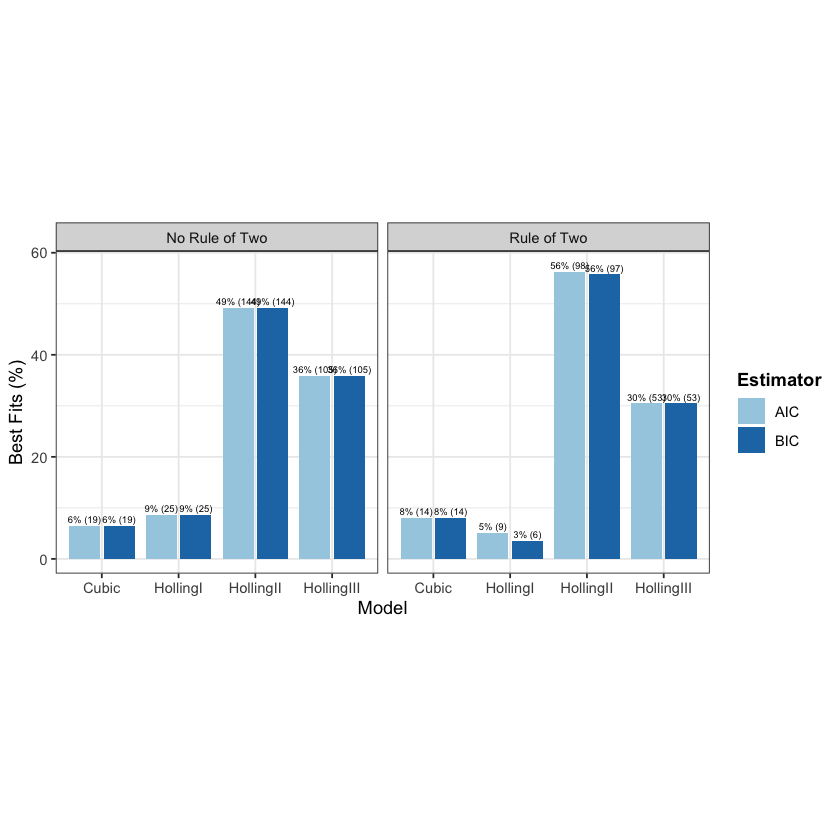

In [502]:
p1 <- plotBestFits(ALLDATA, 'Model')

ggsave("../Results/p1.pdf", p1, width=11, height=5)

p1


* Consistent with general consesus (Hassell et al. 1976, Begon et al. 1996), we observe that the type II functional response was most prevalent in the data, fitting approximately half of all curves for which there was a definitive best model (Fig. 2). This trend remained consistent between both tests, however the relative performance of the type III model improved slightly when the rule of 2 was abandoned (+?%), signifying a significant (t-test?) number of fits for which $\Delta{AIC}<2$ between the type II and type III models. Furthermore, the type I model outperformed the cubic model when the rule was dropped, suggesting a significant number of ties (WHY IS THIS EVEN RELEVANT?)

jkhfghf
* The performance of Holling III improved slightly when the rule of 2 was dropped.
* Both estimators agree on the relative performances of each model category, but disagree marginally on how to score the success of the models within the mechanistic category. More specifically, it is clear that mechanistic models far outperformed their phenomological counterparts, but determining which model wins depends on which estimator one decides to use. THIS IS NOT TRUE! LOOK ABOVE!

### Add column for winning model overall? Or just choose a measure to go by?

* AIC is generally favored due to its roots in Kullback – Leibler infor- mation theory (Johnson Omland)
* BIC includes a penalty term dependent on sample size, and as such favors simpler models, particularly as sample size increases.
* Model averaging to get best?
* For those cases where a tie exists between Holling 2 and GFR, Holl2 was preffered as a matter of parsimony. The penalty for an additional parameter in model selection is +2 AIC units, and as such if $\Delta{AIC}<2$ then the extra explanatory power provided by the additional phenomnological 'q' parameter introduced in the GFR model is insufficient to justify its inclusion. (Arnold 2010)
* As seen above, this adjustment gave Holling's Type II model an overwhelming edge over the other two

# Questions:
1. Which models best fit the data, phenomenological or mechanistic? Why?
2. Which models best fit which consumer foraging movement types (active or passive)? Why might this be?
3. Is there any relationship between habitat and functional response?

### 1. Which models best fit the data, phenomenological or mechanistic? Why?

#### Answer: Mechanistic

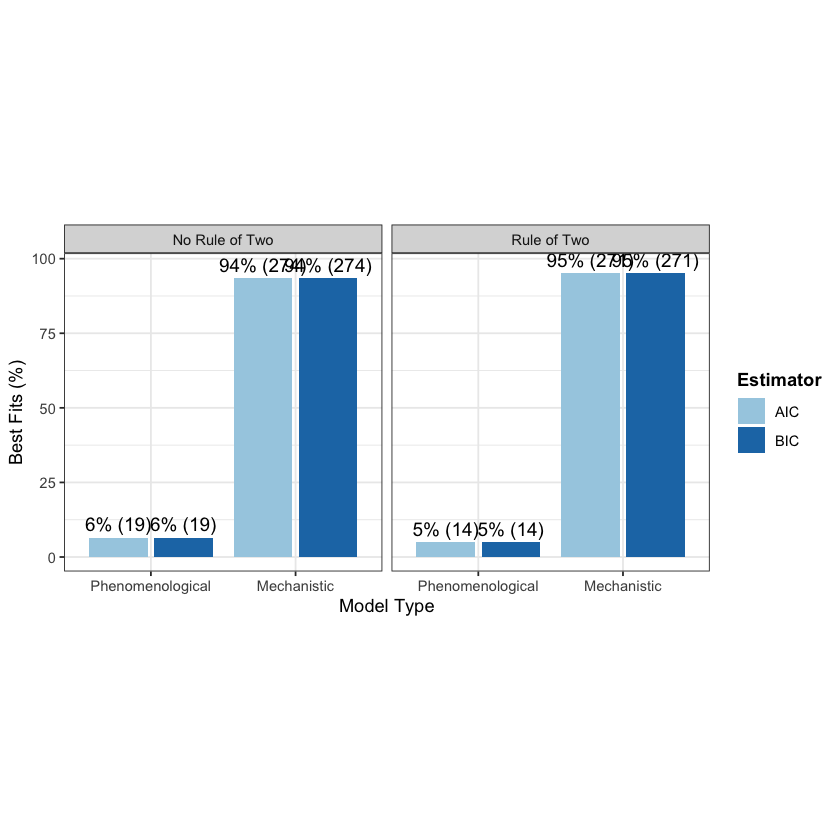

In [503]:
# Plot
p <- plotBestFits(ALLDATA, 'Model Type')

p

ggsave("../Results/p2.pdf", p, width=11, height=5)

#pdf("../Results/foo.pdf", width=11, height=8.5)
#p
#dev.off()

* It is clear that the mechanistic models considerably outperformed their phenomelogical counterpart (Fig. 1). According to both estimators,  approximately 95% of functional responses were best fit by a mechanistic model, regardless of whether or not the rule of 2 was applied (in the case where it was, IDs for which the fits between the two model types could be considered a statistical 'tie' — i.e. $|\Delta{AIC}|<2$ or $|\Delta{BIC}|<2$ — were ignored). 
* This gap would potentially narrow if there were more data points in each functional response, as it would reduce the penalty for the extra parameters ...

* Applying the more conservative Rule of Two 

In [522]:
subset(ALLDATA, BestModelAIC == 'Cubic')
# Holling I - 39896
# Holling II - 39894
# Holling III - 39877, 39899, 39904

ids1 <- c(39896, 39894, 39877, 39899, 39904)


,ID,ResDensityUnit,TraitUnit,ConTaxa,ConCommon,ResTaxa,ResCommon,Habitat,Con_ForagingMovement,Con_MovementDimensionality,⋯,h_Holl3,a_Holl3,BestModelAIC,BestModelBIC,BestModelAIC_NoRule2,BestModelBIC_NoRule2,BestModelTypeAIC,BestModelTypeAIC_NoRule2,BestModelTypeBIC,BestModelTypeBIC_NoRule2
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
22,39856,Individuals per arena,individual / (5 individual * 24 hrs),Saduria entomon (Linnaeus 1758),Benthic isopod,Monoporeia affinis Lindstrm 1855,Amphipod,Marine,active,2D,⋯,3.773193e+04,2.775558e-09,Cubic,Cubic,Cubic,Cubic,Phenomenological,Phenomenological,Phenomenological,Phenomenological
33,39867,Individuals per arena,individual / (1 individual * 3 hrs),Notonecta maculata Fabricius 1794,Backswimmer,Daphnia magna Straus 1820,Daphnia,Freshwater,sessile,3D,⋯,1.271363e+03,1.088019e-06,Cubic,Cubic,Cubic,Cubic,Phenomenological,Phenomenological,Phenomenological,Phenomenological
49,39884,Individuals per arena,individual / (1 individual * 8 hrs),Pardosa vancouveri Emerton,Wolf spider,Drosophila melanogaster Meigen 1830 (wingless),Vestigial-winged drosophila,Terrestrial,active,2D,⋯,1.172293e+04,4.479750e-05,Cubic,Cubic,Cubic,Cubic,Phenomenological,Phenomenological,Phenomenological,Phenomenological
51,39886,Individuals per arena,individual / (1 individual * 6 hrs),Pardosa T-insignita (Boesenberg et Strand),Wolf spider,Drosophila melanogaster Meigen 1830 (wingless),Vestigial-winged drosophila,Terrestrial,active,2D,⋯,1.244757e+04,5.394574e-05,Cubic,Cubic,Cubic,Cubic,Phenomenological,Phenomenological,Phenomenological,Phenomenological
75,39912,Individuals per arena,individual / (1 individual *30 mins),Abramis brama Linneaus,Common bream,Daphnia magna Straus 1820,Daphnia,Freshwater,active,3D,⋯,4.364717e+01,6.113721e-05,Cubic,Cubic,Cubic,Cubic,Phenomenological,Phenomenological,Phenomenological,Phenomenological
88,39926,Individuals per arena,Individual/(Individual*1 day),Nabis kinbergii Reuter,Pacific damsel bug,Sidnia kinbergi Stal 1859,Australian crop mirid,Terrestrial,active,2D,⋯,1.036782e+04,2.149114e-05,Cubic,Cubic,Cubic,Cubic,Phenomenological,Phenomenological,Phenomenological,Phenomenological
112,39951,individuals per arena,Individual/(Individual * 12 hrs),Glossiphonia complanata (Linnaeus 1758),Snail leech,Lymnaea emarginata Say,Snail,Freshwater,active,2D,⋯,3.253155e+03,4.019007e-06,Cubic,Cubic,Cubic,Cubic,Phenomenological,Phenomenological,Phenomenological,Phenomenological
113,39952,individuals per arena,Individual/(Individual * 12 hrs),Glossiphonia complanata (Linnaeus 1758),Snail leech,Lymnaea emarginata Say,Snail,Freshwater,active,2D,⋯,1.861569e+01,7.216450e-08,Cubic,Cubic,Cubic,Cubic,Phenomenological,Phenomenological,Phenomenological,Phenomenological
159,40001,Individuals per milliliter,individual / (1 individual * 1 hour),Streptocephalus torvicornis (Waga 1842),Fairy shrimp,Anuraeopsis fissa Gosse 1851,rotifer,Freshwater,active,3D,⋯,9.713238e-01,7.186474e-05,Cubic,Cubic,Cubic,Cubic,Phenomenological,Phenomenological,Phenomenological,Phenomenological


# Trend Exploration

* No rule of 2
* AIC used - give reason.. (same between the two, sample size?)

## 1. Foraging Movement

In [483]:
suppressMessages(library(janitor))

In [513]:
ALLDATA %>%
tabyl(Con_ForagingMovement, BestModelAIC_NoRule2) %>% # create table
adorn_totals("row") %>% # add total counts
adorn_percentages("row") %>% # add percentages
adorn_pct_formatting(rounding = "half up", digits = 0) %>% # round to 2dp
adorn_ns() %>% # add counts
rename("Consumer Foraging Movement" = "Con_ForagingMovement") # rename columns

,Consumer Foraging Movement,Cubic,HollingI,HollingII,HollingIII
,<chr>,<chr>,<chr>,<chr>,<chr>
1,active,7% (17),10% (23),49% (118),34% (81)
2,sessile,4% (2),4% (2),48% (26),44% (24)
3,Total,6% (19),9% (25),49% (144),36% (105)


* For active consumers, type II most prevalent
* For passive consumers, the type I drops (but aren't many filter feeders passive?) and gap between type II and III shrinks

In [490]:
ALLDATA %>%
tabyl(Res_ForagingMovement, BestModelAIC_NoRule2) %>% # create table
adorn_totals("row") %>% # add total counts
adorn_percentages("row") %>% # add percentages
adorn_pct_formatting(rounding = "half up", digits = 0) %>% # round to 2dp
adorn_ns() %>% # add counts
rename("Resource Foraging Movement" = "Res_ForagingMovement") # rename columns

,Resource Foraging Movement,Cubic,HollingI,HollingII,HollingIII
,<chr>,<chr>,<chr>,<chr>,<chr>
1,active,7% (15),10% (22),47% (102),37% (80)
2,passive,7% (1),7% (1),57% (8),29% (4)
3,sessile,5% (3),3% (2),57% (34),35% (21)
4,Total,6% (19),9% (25),49% (144),36% (105)


...

## Habitat

In [491]:
ALLDATA %>%
tabyl(Habitat, BestModelAIC_NoRule2) %>% # create table
adorn_totals("row") %>% # add total counts
adorn_percentages("row") %>% # add percentages
adorn_pct_formatting(rounding = "half up", digits = 0) %>% # round to 2dp
adorn_ns() # add counts

,Habitat,Cubic,HollingI,HollingII,HollingIII
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Freshwater,6% (11),6% (11),52% (89),35% (60)
2,Marine,3% (2),21% (12),36% (21),40% (23)
3,Terrestrial,9% (6),3% (2),53% (34),34% (22)
4,Total,6% (19),9% (25),49% (144),36% (105)


* Significantly more type I in marine habitats (marine ecosystems have more filter feeders?)
* Marine habitats mostly type III
* Freshwater and terrestrial habitats similar

## Dimensionality

In [499]:
unique(ALLDATA$Con_MovementDimensionality)

[1] "3D"      "2D"      "sessile" ""

In [498]:
ALLDATA %>%
tabyl(Con_MovementDimensionality, BestModelAIC_NoRule2) %>% # create table
adorn_totals("row") %>% # add total counts
adorn_percentages("row") %>% # add percentages
adorn_pct_formatting(rounding = "half up", digits = 0) %>% # round to 2dp
adorn_ns() %>% # add counts
rename("Consumer Movement Dimensionality" = 'Con_MovementDimensionality')

,Consumer Movement Dimensionality,Cubic,HollingI,HollingII,HollingIII
,<chr>,<chr>,<chr>,<chr>,<chr>
1,,3% (1),7% (2),57% (17),33% (10)
2,2D,8% (7),10% (9),47% (43),35% (32)
3,3D,6% (11),8% (14),49% (84),36% (61)
4,sessile,0% (0),0% (0),0% (0),100% (2)
5,Total,6% (19),9% (25),49% (144),36% (105)


* Differences between 2D and 3D negligible 

In [500]:
ALLDATA %>%
tabyl(Res_MovementDimensionality, BestModelAIC_NoRule2) %>% # create table
adorn_totals("row") %>% # add total counts
adorn_percentages("row") %>% # add percentages
adorn_pct_formatting(rounding = "half up", digits = 0) %>% # round to 2dp
adorn_ns() %>% # add counts
rename("Resource Movement Dimensionality" = 'Res_MovementDimensionality')

,Resource Movement Dimensionality,Cubic,HollingI,HollingII,HollingIII
,<chr>,<chr>,<chr>,<chr>,<chr>
1,,3% (1),7% (2),57% (17),33% (10)
2,2D,10% (9),9% (8),43% (38),38% (33)
3,3D,6% (9),9% (15),48% (77),36% (58)
4,sessile,0% (0),0% (0),75% (12),25% (4)
5,Total,6% (19),9% (25),49% (144),36% (105)


* Same as above

In [501]:
ALLDATA %>%
tabyl(Con_RESDetectionDimensionality, BestModelAIC_NoRule2) %>% # create table
adorn_totals("row") %>% # add total counts
adorn_percentages("row") %>% # add percentages
adorn_pct_formatting(rounding = "half up", digits = 0) %>% # round to 2dp
adorn_ns() %>% # add counts
rename("Consumer-Resource Detection Dimensionality" = 'Con_RESDetectionDimensionality')

,Consumer-Resource Detection Dimensionality,Cubic,HollingI,HollingII,HollingIII
,<chr>,<chr>,<chr>,<chr>,<chr>
1,half-sphere,3% (1),6% (2),39% (12),52% (16)
2,sphere,6% (8),10% (14),50% (69),34% (47)
3,surface,8% (10),7% (9),51% (63),34% (42)
4,Total,6% (19),9% (25),49% (144),36% (105)


Not sure if I've interpreted these correctly, but if so then: 
* Type II generally for 360° detection
* Type III for 180° detection
* Type II for 'surface' (?)

In [495]:
ALLDATA %>%
tabyl(Res_CONDetectionDimensionality, BestModelAIC_NoRule2) %>% # create table
adorn_totals("row") %>% # add total counts
adorn_percentages("row") %>% # add percentages
adorn_pct_formatting(rounding = "half up", digits = 0) %>% # round to 2dp
adorn_ns() %>% # add counts
rename("Resource-Consumer Detection Dimensionality" = 'Res_CONDetectionDimensionality')

,Resource-Consumer Detection Dimensionality,Cubic,HollingI,HollingII,HollingIII
,<chr>,<chr>,<chr>,<chr>,<chr>
1,half-sphere,50% (1),0% (0),50% (1),0% (0)
2,sphere,5% (9),10% (16),47% (79),38% (63)
3,surface,7% (9),7% (9),52% (64),34% (42)
4,Total,6% (19),9% (25),49% (144),36% (105)


## Taxonomy

# Filter Feeders

Preliminary plotting functions:

In [8]:
plotBestFits <- function(df, fac){
  # Evaluate args
  if(!fac %in% c('Model', 'Model Type')) return("fac must be one of: 'Model', 'Type'")

  # no of levels
  no <- ifelse(fac=='Model Type', 2, model_count)
  
  # define levels
  if (fac == 'Model Type'){
    lvls <- c('Phenomenological', 'Mechanistic')
    aicBreakdown <- table(ALLDATA[,'BestModelTypeAIC_NoRule2'], ALLDATA$FilterFeeder)
    bicBreakdown <- table(ALLDATA[,'BestModelTypeBIC_NoRule2'], ALLDATA$FilterFeeder)
    aicBreakdownRO2 <- table(ALLDATA[,'BestModelTypeAIC'], ALLDATA$FilterFeeder)
    bicBreakdownRO2 <- table(ALLDATA[,'BestModelTypeBIC'], ALLDATA$FilterFeeder)
  } else { # if fac == 'Model'
    lvls <- model_names
    aicBreakdown <- table(ALLDATA[,'BestModelAIC_NoRule2'], ALLDATA$FilterFeeder)
    bicBreakdown <- table(ALLDATA[,'BestModelBIC_NoRule2'], ALLDATA$FilterFeeder)
    aicBreakdownRO2 <- table(ALLDATA[,'BestModelAIC'], ALLDATA$FilterFeeder)
    bicBreakdownRO2 <- table(ALLDATA[,'BestModelBIC'], ALLDATA$FilterFeeder)
  }
  
  fitdata <- data.frame(Level = rep(lvls, times = 8), 
                        Estimator = rep(c('AIC', 'BIC'), each = 2*no, times = 2),
                        FeedType = rep(c('Filter feeder', 'Non-filter feeder'), times = 4, each=no),
                        RO2 = rep(c('Rule of Two', 'No Rule of Two'), each = 4*no),
                        Count = rep(NA, times = 8*no))
  
  # Load count of how many IDs were definititvely best fit by each model (draws excluded)
  for (i in 1:nrow(fitdata)){
    lvl <- fitdata[i,'Level']
    stat <- fitdata[i,'Estimator']
    ro2 <- fitdata[i,'RO2']
    feedtype <- fitdata[i,'FeedType']
    if (ro2 == 'No Rule of Two'){
      if (stat == 'AIC'){
        fitdata[i,'Count'] <- ifelse(is.na(aicBreakdown[lvl, feedtype]), 0, aicBreakdown[[lvl, feedtype]])
      } else {
        fitdata[i,'Count'] <- ifelse(is.na(bicBreakdown[lvl, feedtype]), 0, bicBreakdown[[lvl, feedtype]])
      }
    } else {
      if (stat == 'AIC'){
        fitdata[i,'Count'] <- ifelse(is.na(aicBreakdownRO2[lvl, feedtype]), 0, aicBreakdownRO2[[lvl, feedtype]])
      } else {
        fitdata[i,'Count'] <- ifelse(is.na(bicBreakdownRO2[lvl, feedtype]), 0, bicBreakdownRO2[[lvl, feedtype]])
      }
    }
  }
  
  n <- as.vector(sapply(split(fitdata$Count, ceiling(seq_along(fitdata$Count)/no)), sum)) # Split count col into 4s and add each to get relative total
  fitdata$Total <- rep(n, each = no)
  fitdata$Percentage <- round((fitdata$Count/fitdata$Total)*100) # Add percentage of IDs best fit
  # when the rule of 2 is applied there will be different totals (as ties are ignored)
  
  # Plot
  p <- ggplot(data = fitdata, aes(x = factor(Level, levels = lvls), y = Percentage, fill = Estimator)) + 
    facet_grid(RO2 ~ FeedType) +
    geom_bar(stat="identity", position = 'dodge2') +
    labs(x = fac, y = 'Best Fits (%)') + 
    theme_bw() +
    theme(legend.title = element_text(face="bold")) +
    geom_text(aes(label=paste(round(Percentage), '% (', Count, ')', sep = '')), position=position_dodge(width=0.9), vjust=-0.5, cex = 3.5-0.5*no) +
    scale_fill_brewer(palette="Paired") +
    scale_y_continuous(limits=c(0,max(fitdata$Percentage)*1.02))
  
  return(p)
}

# Function for adding a column specifying whether the organism is a filter feeder
filterFeed <- function(vec){
  # Strip spaces and convert to lowercase
  stnd <- tolower(gsub(' ', '', vec, fixed = TRUE))
  filtfeeders <- c('rotifer', 'shrimp', 'copepod', 'daphnia', 'amphipod', 'krill', 
                   'euphasiid', 'amphipod', 'larva', 'larvae', 'maggot', 'bivalve', 
                   'appendicularian', 'polychaete', 'bladderwort', 'seastar', 
                   'webbuilder')
  pattern <- paste(filtfeeders, collapse = '|')
  result <- grepl(pattern, stnd)
  return(sapply(result, function(x) ifelse(isTRUE(x), 'Filter feeder', 'Non-filter feeder')))
}

Add Feed Type column:

In [9]:
ALLDATA$FilterFeeder <- filterFeed(ALLDATA$ConCommon) # Add filter feed column

## Phenomenological vs. Mechanistic

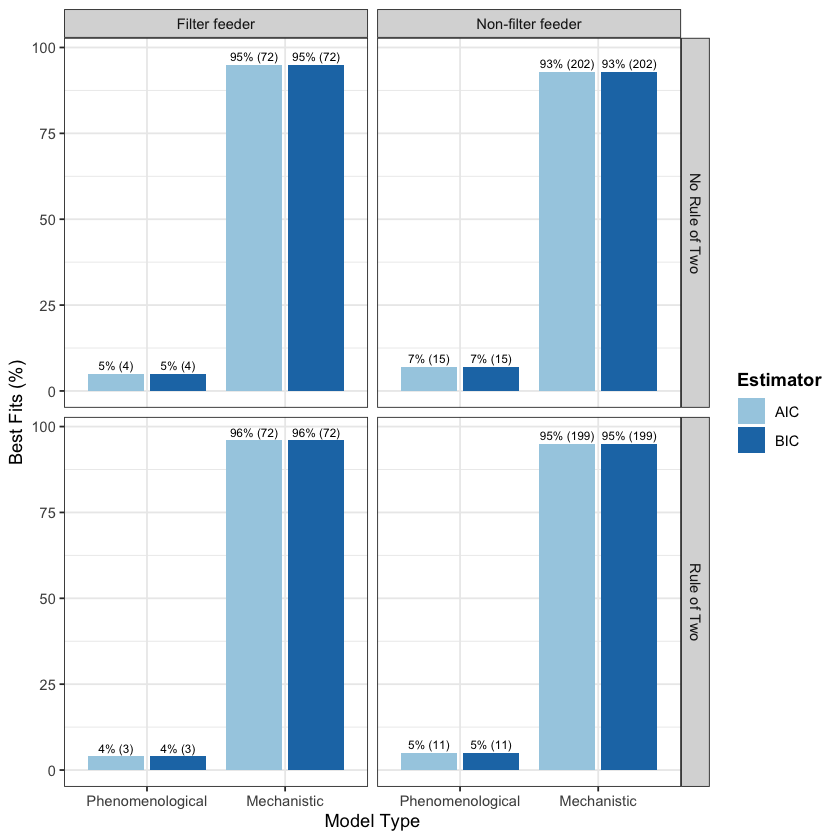

In [10]:
plotBestFits(ALLDATA, 'Model Type')

In [707]:
types <- table(ALLDATA$FilterFeeder, ALLDATA$BestModelTypeAIC_NoRule2)
types <- types[,which(colnames(types) %in% c('Mechanistic', 'Phenomenological'))] # ignore ties (if rule of 2)
filt <- prop.test(x = types[1,'Mechanistic'], sum(types[1,]), p = 0.5, correct = FALSE)
nonfilt <- prop.test(x = types[2,'Mechanistic'], sum(types[2,]), p = 0.5, correct = FALSE)
filt$p.value
nonfilt$p.value

[1] 6.184101e-15

[1] 6.352525e-37

In [708]:
types <- table(ALLDATA$FilterFeeder, ALLDATA$BestModelTypeAIC)
types <- types[,which(colnames(types) %in% c('Mechanistic', 'Phenomenological'))] # ignore ties (if rule of 2)
filt <- prop.test(x = types[1,'Mechanistic'], sum(types[1,]), p = 0.5, correct = FALSE)
nonfilt <- prop.test(x = types[2,'Mechanistic'], sum(types[2,]), p = 0.5, correct = FALSE)
filt$p.value
nonfilt$p.value

[1] 1.620033e-15

[1] 1.735538e-38

**It is clear that mechnistic models considerably outperformed their phenomonological counterpart accross the board (Fig. 1).** According to both estimators, approximately 95% of functional responses were best fit by a mechanistic model, regardless of feeding type or whether or not the Rule of Two was applied ($p<$0.1e-15 in all cases).

($p<$0.1e-15 for both feeding types, both estimators, and both analytical rules)**


* It is clear that the mechanistic models considerably outperformed their phenomelogical counterpart (Fig. 1). According to both estimators,  approximately 95% of functional responses were best fit by a mechanistic model, regardless of whether or not the rule of 2 was applied (in the case where it was, IDs for which the fits between the two model types could be considered a statistical 'tie' — i.e. $|\Delta{AIC}|<2$ or $|\Delta{BIC}|<2$ — were ignored). 
* This gap would potentially narrow if there were more data points in each functional response, as it would reduce the penalty for the extra parameters ...

ONLY ONE OF THESE^ NEEDED TO DEMONSTRATE (MORE CONSERVATIVE RULE OF TWO ONE)??
You could add an ifelse statement in the function of whether or not to fecet grid just by one or two varibles (i.e. if .. p <- p + fcet_grid(...) else ... p <- p + fcet_grid(...) .. then show chi sqd of the other

RULE OF 2 DOESN'T MATTER HERE AS CALCULATED SIMILARLY FOR MODEL TYPE

## Individual Model Comparison

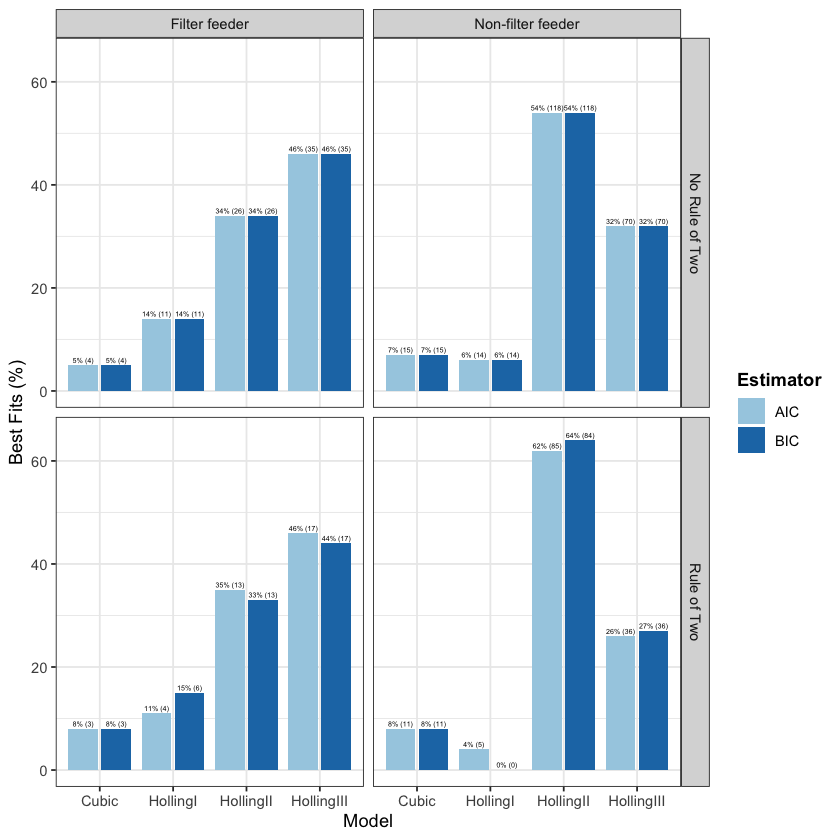

In [11]:
plotBestFits(ALLDATA, 'Model')

## Jeshke: not all filter feeders exhibit type I functional responses, but all type I functional responses belong to filter feeders

In [788]:

hol3filtfeed[,c(1,4,5,8,9,10,11,15)]
hol3filtfeed$ID

,ID,ConTaxa,ConCommon,Habitat,Con_ForagingMovement,Con_MovementDimensionality,Con_RESDetectionDimensionality,LabField
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
48,39883,Chrysomya albiceps (Wiedemann 1819),Blow fly maggot,Terrestrial,active,2D,surface,laboratory
62,39899,Chaoborus americanus Johannsen 1903,Phantom midge larva,Freshwater,sessile,3D,half-sphere,laboratory
64,39901,Chaoborus americanus Johannsen 1903,Phantom midge larva,Freshwater,sessile,3D,half-sphere,laboratory
67,39904,Chaoborus americanus Johannsen 1903,Phantom midge larva,Freshwater,sessile,3D,half-sphere,laboratory
110,39949,Ephemerella aurivilli,Mayfly larva,Freshwater,active,2D,surface,laboratory
133,39973,Daphnia pulicaria Forbes 1893,Daphnia,Freshwater,active,3D,sphere,laboratory
145,39987,Mercenaria mercenaria (Linnaeus 1758),Quahog larva,Marine,active,3D,sphere,laboratory
151,39993,Nyctiphanes australis Sars 1883,Euphausiid krill,Marine,active,3D,sphere,laboratory
155,39997,Tortanus forcipatus (Giesbrecht 1889),Copepod,Marine,active,3D,sphere,laboratory


[1] 39883 39899 39901 39904 39949 39973 39987 39993 39997 39999 40006 40017
[13] 40035 40061 40064 40099 40105

In [783]:
# Filter feeder type III 
names(ALLDATA)
hol3filtfeed <- ALLDATA[ALLDATA$BestModelAIC == 'HollingIII' & ALLDATA$FilterFeeder == 'Filter feeder',]

hol3filtfeed %>%
tabyl(LabField) %>% # create table
adorn_pct_formatting(rounding = "half up", digits = 0) %>%
rename("Count" = 'n', 'Proportion' = 'percent')

ALLDATA %>%
tabyl(LabField) %>% # create table
adorn_pct_formatting(rounding = "half up", digits = 0) %>%
rename("Count" = 'n', 'Proportion' = 'percent')

hol3filtfeed %>%
tabyl(Habitat) %>% # create table
adorn_pct_formatting(rounding = "half up", digits = 0) %>%
rename("Count" = 'n', 'Proportion' = 'percent')

ALLDATA %>%
tabyl(Habitat) %>% # create table
adorn_pct_formatting(rounding = "half up", digits = 0) %>%
rename("Count" = 'n', 'Proportion' = 'percent')

hol3filtfeed %>%
tabyl(Con_ForagingMovement) %>% # create table
adorn_pct_formatting(rounding = "half up", digits = 0) %>%
rename("Count" = 'n', 'Proportion' = 'percent')

hol3filtfeed %>%
tabyl(Con_MovementDimensionality) %>% # create table
adorn_pct_formatting(rounding = "half up", digits = 0) %>%
rename("Count" = 'n', 'Proportion' = 'percent')

hol3filtfeed %>%
tabyl(Con_RESDetectionDimensionality) %>% # create table
adorn_pct_formatting(rounding = "half up", digits = 0) %>%
rename("Count" = 'n', 'Proportion' = 'percent')

#%>%
#tidyr::unite('Count', n:percent, sep = ' (')


#tabyl(Con_RESDetectionDimensionality, BestModelAIC_NoRule2) %>% # create table
#adorn_totals("row") %>% # add total counts
#adorn_percentages("row") %>% # add percentages
#adorn_pct_formatting(rounding = "half up", digits = 0) %>% # round to 2dp
#adorn_ns() %>% # add counts
#rename("Consumer-Resource Detection Dimensionality" = 'Con_RESDetectionDimensionality')

#%>% # create table
#adorn_totals("col") %>% # add total counts
#adorn_percentages("col") %>% # add percentages
#adorn_pct_formatting(rounding = "half up", digits = 0) 


[1] "ID"                             "ResDensityUnit"                
 [3] "TraitUnit"                      "ConTaxa"                       
 [5] "ConCommon"                      "ResTaxa"                       
 [7] "ResCommon"                      "Habitat"                       
 [9] "Con_ForagingMovement"           "Con_MovementDimensionality"    
[11] "Con_RESDetectionDimensionality" "Res_ForagingMovement"          
[13] "Res_MovementDimensionality"     "Res_CONDetectionDimensionality"
[15] "LabField"                       "Cubic_AIC"                     
[17] "HollingI_AIC"                   "HollingII_AIC"                 
[19] "HollingIII_AIC"                 "Cubic_BIC"                     
[21] "HollingI_BIC"                   "HollingII_BIC"                 
[23] "HollingIII_BIC"                 "a_Holl1"                       
[25] "h_Holl2"                        "a_Holl2"                       
[27] "h_Holl3"                        "a_Holl3"                       
[29] "BestModelAIC"                   "BestModelBIC"                  
[31] "BestModelAIC_NoRule2"           "BestModelBIC_NoRule2"          
[33] "BestModelTypeAIC"               "BestModelTypeAIC_NoRule2"      
[35] "BestModelTypeBIC"               "BestModelTypeBIC_NoRule2"      
[37] "FilterFeeder"

LabField,Count,Proportion
<chr>,<dbl>,<chr>
laboratory,17,100%


LabField,Count,Proportion
<chr>,<dbl>,<chr>
enclosure,19,6%
field,10,3%
laboratory,264,90%


Habitat,Count,Proportion
<chr>,<dbl>,<chr>
Freshwater,9,53%
Marine,7,41%
Terrestrial,1,6%


Habitat,Count,Proportion
<chr>,<dbl>,<chr>
Freshwater,171,58%
Marine,58,20%
Terrestrial,64,22%


Con_ForagingMovement,Count,Proportion
<chr>,<dbl>,<chr>
active,12,71%
sessile,5,29%


Con_MovementDimensionality,Count,Proportion
<chr>,<dbl>,<chr>
2D,4,24%
3D,12,71%
sessile,1,6%


Con_RESDetectionDimensionality,Count,Proportion
<chr>,<dbl>,<chr>
half-sphere,5,29%
sphere,8,47%
surface,4,24%


#### LabField

In [870]:
keys <- unique(ALLDATA$LabField)
all <- as.list(table(ALLDATA$LabField))
filts <- as.list(table(hol3filtfeed$LabField))

for (key in keys){
    if(is.null(filts[[key]])){filts[[key]] <- 0}
}

all <- all[keys]
filts <- filts[keys]
exptype <- data.frame(rbind(unlist(all), unlist(filts)))

exptype

chisq.test(exptype)

laboratory,enclosure,field
<dbl>,<dbl>,<dbl>
264,19,10
17,0,0


Warning message in stats::chisq.test(x, y, ...):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  exptype
X-squared = 1.8562, df = 2, p-value = 0.3953


Insignificant difference

#### Habitat

In [871]:
keys <- unique(ALLDATA$Habitat)
all <- as.list(table(ALLDATA$Habitat))
filts <- as.list(table(hol3filtfeed$Habitat))

for (key in keys){
    if(is.null(filts[[key]])){filts[[key]] <- 0}
}

all <- all[keys]
filts <- filts[keys]
hab <- data.frame(rbind(unlist(all), unlist(filts)))

hab

chisq.test(hab)

Freshwater,Marine,Terrestrial
<int>,<int>,<int>
171,58,64
9,7,1


Warning message in stats::chisq.test(x, y, ...):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  hab
X-squared = 5.5367, df = 2, p-value = 0.06277


Insignificant difference

#### Con_ForagingMovement

In [861]:
keys <- unique(ALLDATA$Con_ForagingMovement)
all <- as.list(table(ALLDATA$Con_ForagingMovement))
filts <- as.list(table(hol3filtfeed$Con_ForagingMovement))

for (key in keys){
    if(is.null(filts[[key]])){filts[[key]] <- 0}
}

all <- all[keys]
filts <- filts[keys]
hab <- data.frame(rbind(unlist(all), unlist(filts)))

hab

chisq.test(hab)

active,sessile
<int>,<int>
239,54
12,5


Warning message in stats::chisq.test(x, y, ...):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test with Yates' continuity correction

data:  hab
X-squared = 0.64579, df = 1, p-value = 0.4216


Insignificant difference

#### Con_MovementDimensionality

In [869]:
keys <- unique(ALLDATA$Con_MovementDimensionality)
all <- as.list(table(ALLDATA$Con_MovementDimensionality))
filts <- as.list(table(hol3filtfeed$Con_MovementDimensionality))

for (key in keys){
    if(is.null(filts[[key]])){filts[[key]] <- 0}
}

# Order lists
all <- all[keys] 
filts <- filts[keys]

# Build df for chi sqd test
dim <- data.frame(rbind(unlist(all), unlist(filts)))

dim$sessile <- NULL

chisq.test(dim)


	Pearson's Chi-squared test with Yates' continuity correction

data:  dim
X-squared = 0.28697, df = 1, p-value = 0.5922


## Is there a significant difference in proportion of type I functional responses between filter feeders/non-filter feeders? 
If this is true, then we should see a significant difference in performance of type I model between filter feeders and non-filter feeders.

### No Rule of Two:

In [660]:
mods <- table(ALLDATA$FilterFeeder, ALLDATA$BestModelAIC_NoRule2)
mods <- mods[,which(colnames(mods) %in% c('Cubic', 'HollingI', 'HollingII', 'HollingIII'))] # ignore ties (if rule of 2)
modscomp1 <- as.data.frame.matrix(mods)
modscomp1$NonTypeI <- modscomp1$Cubic + modscomp1$HollingII + modscomp1$HollingIII
modscomp1$Cubic <- modscomp1$HollingII <- modscomp1$HollingIII <- NULL
modscomp1
chisq.test(modscomp1)

,HollingI,NonTypeI
,<int>,<int>
Filter feeder,11,65
Non-filter feeder,14,203



	Pearson's Chi-squared test with Yates' continuity correction

data:  modscomp1
X-squared = 3.6703, df = 1, p-value = 0.05539


In [663]:
modscomp2 <- as.data.frame.matrix(mods)
modscomp2$NonTypeII <- modscomp2$Cubic + modscomp2$HollingI + modscomp2$HollingIII
modscomp2$Cubic <- modscomp2$HollingI <- modscomp2$HollingIII <- NULL
modscomp2
chisq.test(modscomp2)

,HollingII,NonTypeII
,<int>,<int>
Filter feeder,26,50
Non-filter feeder,118,99



	Pearson's Chi-squared test with Yates' continuity correction

data:  modscomp2
X-squared = 8.3707, df = 1, p-value = 0.003813


In [664]:
modscomp3 <- as.data.frame.matrix(mods)
modscomp3$NonTypeIII <- modscomp3$Cubic + modscomp3$HollingI + modscomp3$HollingII
modscomp3$Cubic <- modscomp3$HollingI <- modscomp3$HollingII <- NULL
modscomp3
chisq.test(modscomp3)

,HollingIII,NonTypeIII
,<int>,<int>
Filter feeder,35,41
Non-filter feeder,70,147



	Pearson's Chi-squared test with Yates' continuity correction

data:  modscomp3
X-squared = 4.0775, df = 1, p-value = 0.04346


### Conclusion
* **If the Rule of Two is ignored then the difference in type I performance between filter feeders and non-filter feeders is statistically insignificant on both estimators ($\chi^2=3.6703; df = 1; p>0.05$)**
* A significantly higher proportion of type II functional responses in the non-filter feeder data set ($\chi^2=8.3707; df = 1; p<0.005$). Due to comparitively high handling times and irregular search rates preventing a type I response and infrequency of learning or switching effects preventing a type III response (JEche 2004 p 343).
* A significantly higher proportion of type III functional responses in the filter feeder data set ($\chi^2=4.0775; df = 1; p<0.05$). Jaeshke speculates that this may be due to the consumer lowering its filtration rates at low resource densities (PAGE NO). 


The metadata failed to explain this

However, it is worth noting that ALL OF THESE WERE IN A LAB CONTEXT (typically high resource desnities-samraat), (lab contexts high res density - samraat, also scan ives1999 as jesche2004 cites this). PRACTICALLY ALL WERE IN AQUATIC HABITAT.

### Rule of Two:

In [632]:
mods <- table(ALLDATA$FilterFeeder, ALLDATA$BestModelAIC)
mods <- mods[,which(colnames(mods) %in% c('Cubic', 'HollingI', 'HollingII', 'HollingIII'))] # ignore ties (if rule of 2)
mods <- as.data.frame.matrix(mods)
mods$NonTypeI <- mods$Cubic + mods$HollingII + mods$HollingIII
mods$Cubic <- mods$HollingII <- mods$HollingIII <- NULL
mods
chisq.test(mods)

,HollingI,NonTypeI
,<int>,<int>
Filter feeder,4,33
Non-filter feeder,5,132


Warning message in stats::chisq.test(x, y, ...):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test with Yates' continuity correction

data:  mods
X-squared = 1.7608, df = 1, p-value = 0.1845


In [633]:
mods <- table(ALLDATA$FilterFeeder, ALLDATA$BestModelBIC)
mods <- mods[,which(colnames(mods) %in% c('Cubic', 'HollingI', 'HollingII', 'HollingIII'))] # ignore ties (if rule of 2)
mods <- as.data.frame.matrix(mods)
mods$NonTypeI <- mods$Cubic + mods$HollingII + mods$HollingIII
mods$Cubic <- mods$HollingII <- mods$HollingIII <- NULL
mods
chisq.test(mods)

,HollingI,NonTypeI
,<int>,<int>
Filter feeder,6,33
Non-filter feeder,0,131


Warning message in stats::chisq.test(x, y, ...):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test with Yates' continuity correction

data:  mods
X-squared = 16.617, df = 1, p-value = 4.574e-05


### Conclusion:
**However when the Rule of Two is employed, whilst the performance difference is still statistically insignificant according to the AIC ($\chi^2=1.7608; df = 1; p>0.1$), it is highly significant according to BIC ($\chi^2=16.617; df = 1; p<0.0001$)**

From this we can draw a few conclusions:
1. The majority of functional responses in the non-filter feeder dataset that are deemed type I when the Rule of Two is abandoned are actually mixed responses (e.g. type I/II responses), as hypothesized by J. (All 14 according to BIC and 9/14 according to AIC)
2. This brings our results into closer aligment with JEshke's (2004) claim that deifnitive type 1 functional responses are exclusive to filter feeders. 


**What are the definitive non-filter feeder type I responses according to AIC?**
* Given that BIC penalizes model complexity more heavily than does AIC, the result that AIC definitively favours the simplest model in cases where BIC doesn't is at first glance a counter-intuitive one. However, this is readily explained by the low sample size for these data sets. For each of the 5 functional responses labelled type I by the AIC estimator, the sample size is small ($<7$), meaning that these datasets are within the sample size window for which BIC is more tolerant of extra params than AIC ($N\leqslant7\implies ln(N)<2$) and is accordingly putting the BIC scores of the higher order Holling models within range ($\Delta_i<2$) of the type I.
* Possible explanations:
    1. $\Delta{AIC}<2.09$ for all; only a very slight edge.
    2. 

(All 14 according to BIC and 9/14 according to AIC).

*'Type I functional responses have only been reported from filter feeders (Fig. 2); the small fraction of type I responses reported from non-filter feeders was derived from intermediate responses (e.g. type I/II responses)' (Jesh 2004)*

# Plotting Individual Curves

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name              grob
1 1 (1-1,1-1) arrange   gtable[arrange]
2 2 (1-1,2-2) arrange gtable[guide-box]

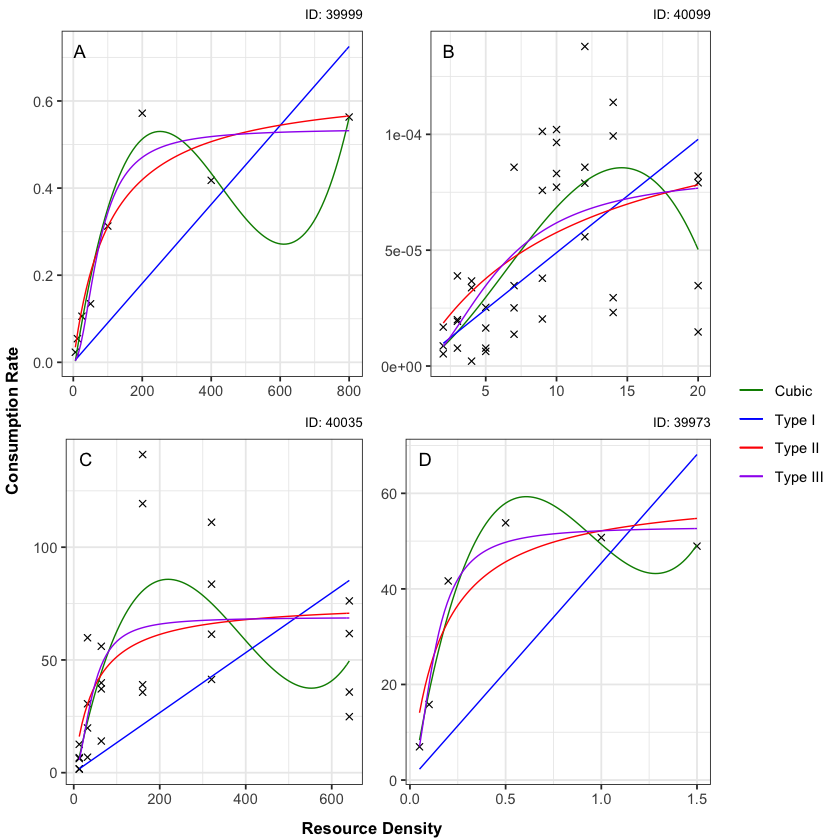

In [20]:
## Functions ##
holling2 <- function(R, a, h){
  num <- a*R
  denom <- 1+a*h*R
  return(num/denom)
}

holling3 <- function(R, a, h){
  num <- a*R^2
  denom <- 1+a*h*R^2
  return(num/denom)
}


plotFits <- function(id){
  df <- subset(frData, ID == id)
  stats <- subset(frModStats, ID == id)
  
  try({
    id <- unique(df$ID)
    
    ResDensity <- df$ResDensity
    N_TraitValue <- df$N_TraitValue
    x_units <- unique(df$ResDensityUnit)
    y_units <- unique(df$TraitUnit)
    
    # Fit models
    #Quad <- lm(y ~ poly(x, 2))
    Cube <- lm(N_TraitValue ~ poly(ResDensity, 3))
    
    # Generate a vector of the the x-axis variable
    x <- seq(from = min(ResDensity), to = max(ResDensity), by = ((max(ResDensity) - min(ResDensity))/100))
    
    
    # Calculate predicted lines and write points to dataframe
    y_cube <- predict.lm(Cube, data.frame(ResDensity = x))
    y_holl1 <- stats$a_Holl1 * x
    y_holl2 <- holling2(x, stats$a_Holl2, stats$h_Holl2)
    y_holl3 <- holling3(x, stats$a_Holl3, stats$h_Holl3)
    
    data_to_fit <- data.frame(x = x, y_cube = y_cube, y_holl1 = y_holl1, y_holl2 = y_holl2, y_holl3 = y_holl3)
    
    # Plot
    p <- ggplot(aes(x = ResDensity, y = N_TraitValue), data = df) +
      geom_point(shape=I(4)) + theme_bw() +
      ggtitle(paste("ID:", id)) +
      theme(plot.title = element_text(size=8, hjust = 1)) +
      theme(legend.position = 'right') +
      xlab(NULL) +
      ylab(NULL) +
      geom_line(aes(x = x, y = y_cube, colour = "Cubic"), data = data_to_fit, size = 0.4) +
      geom_line(aes(x = x, y = y_holl1, colour = "Type I"), data = data_to_fit, size = 0.4) + 
      geom_line(aes(x = x, y = y_holl2, colour = "Type II"), data = data_to_fit, size = 0.4) +
      geom_line(aes(x = x, y = y_holl3, colour = "Type III"), data = data_to_fit, size = 0.4) +
      scale_colour_manual("", breaks = c("Cubic", "Type I", "Type II", "Type III"), values = c("green4", "blue", "red", "purple")) 
    
    if (id == 39999){
      p <- p + annotate(geom = 'text', label = 'A', x = -Inf, y = Inf, hjust = -1, vjust = 2)
    } else if (id == 40099){
          p <- p + annotate(geom = 'text', label = 'B', x = -Inf, y = Inf, hjust = -1, vjust = 2)
    } else if (id == 40035){
      p <- p + annotate(geom = 'text', label = 'C', x = -Inf, y = Inf, hjust = -1, vjust = 2)
    } else if (id == 39973){
      p <- p + annotate(geom = 'text', label = 'D', x = -Inf, y = Inf, hjust = -1, vjust = 2)
    } else {
      return(p)
    }
    
    return(p)
  }, silent = TRUE)
}

#cub <- plotFits(39951) + theme(axis.text.x = element_blank(), axis.text.y = element_blank()) + xlab(NULL)
#t1 <- plotFits(39896) + theme(axis.text.x = element_blank(), axis.text.y = element_blank()) + ylab(NULL) + xlab(NULL)
#t2 <- plotFits(39894) + theme(axis.text.x = element_blank(), axis.text.y = element_blank())
#t3 <- plotFits(39904) + theme(axis.text.x = element_blank(), axis.text.y = element_blank()) + ylab(NULL)

#pl <- lapply(c(39854, 39858, 39896, 40010), FUN = plotFits)
pl <- lapply(c(39999, 40099, 40035, 39973), FUN = plotFits)


# Function to extract legend
# https://github.com/hadley/ggplot2/wiki/Share-a-legend-between-two-ggplot2-graphs
g_legend <- function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend) 
}

# Extract legend as a grob
leg = g_legend(pl[[1]])

demplots <- grid.arrange(
  arrangeGrob(grobs=lapply(pl, function(p) p + guides(colour=FALSE)), ncol=2,
              bottom=textGrob("Resource Density", gp=gpar(fontface="bold", fontsize=10)), 
              left=textGrob("Consumption Rate", gp=gpar(fontface="bold", fontsize=10), rot=90)),
  leg, 
  widths=c(9,1.5)
)
    
demplots

In [692]:
ALLDATA[ALLDATA$BestModelAIC == 'HollingI' & ALLDATA$FilterFeeder == 'Non-filter feeder',][,c(1,16:37)]
idsss <- unique(ALLDATA[ALLDATA$BestModelAIC == 'HollingI' & ALLDATA$FilterFeeder == 'Non-filter feeder',][,c(1,16:37)]$ID)
weirdsets <- frData[frData$ID %in% idsss,]
ALLDATA[ALLDATA$BestModelAIC == 'HollingI' & ALLDATA$FilterFeeder == 'Filter feeder',][,c(1,16:37)]


,ID,Cubic_AIC,HollingI_AIC,HollingII_AIC,HollingIII_AIC,Cubic_BIC,HollingI_BIC,HollingII_BIC,HollingIII_BIC,a_Holl1,⋯,a_Holl3,BestModelAIC,BestModelBIC,BestModelAIC_NoRule2,BestModelBIC_NoRule2,BestModelTypeAIC,BestModelTypeAIC_NoRule2,BestModelTypeBIC,BestModelTypeBIC_NoRule2,FilterFeeder
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
20,39854,-115.13648,-129.82829,-127.81728,-118.65086,-115.91760,-130.21885,-128.59841,-119.43199,4.899293e-08,⋯,2.775558e-09,HollingI,HollingI/HollingII,HollingI,HollingI,Mechanistic,Mechanistic,Mechanistic,Mechanistic,Non-filter feeder
24,39858,-103.23444,-117.96548,-115.87164,-111.28198,-104.01556,-118.35604,-116.65277,-112.06310,1.003688e-07,⋯,2.775558e-09,HollingI,HollingI/HollingII,HollingI,HollingI,Mechanistic,Mechanistic,Mechanistic,Mechanistic,Non-filter feeder
53,39890,-96.82587,-110.84296,-108.84279,-107.38072,-97.24235,-111.05120,-109.25927,-107.79720,9.325202e-06,⋯,4.163336e-07,HollingI,HollingI/HollingII/HollingIII,HollingI,HollingI,Mechanistic,Mechanistic,Mechanistic,Mechanistic,Non-filter feeder
240,40089,-75.36880,-91.03830,-89.03790,-86.91076,-75.78528,-91.24654,-89.45438,-87.32724,3.159978e-05,⋯,9.325873e-07,HollingI,HollingI/HollingII,HollingI,HollingI,Mechanistic,Mechanistic,Mechanistic,Mechanistic,Non-filter feeder
245,40094,-74.91946,-90.52838,-88.52652,-85.54535,-75.33594,-90.73662,-88.94300,-85.96183,4.813182e-05,⋯,1.496026e-06,HollingI,HollingI/HollingII,HollingI,HollingI,Mechanistic,Mechanistic,Mechanistic,Mechanistic,Non-filter feeder


,ID,Cubic_AIC,HollingI_AIC,HollingII_AIC,HollingIII_AIC,Cubic_BIC,HollingI_BIC,HollingII_BIC,HollingIII_BIC,a_Holl1,⋯,a_Holl3,BestModelAIC,BestModelBIC,BestModelAIC_NoRule2,BestModelBIC_NoRule2,BestModelTypeAIC,BestModelTypeAIC_NoRule2,BestModelTypeBIC,BestModelTypeBIC_NoRule2,FilterFeeder
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
59,39896,-124.19697,-144.17445,-142.17444,-138.14861,-124.03809,-144.09501,-142.01556,-137.98972,4.498777e-05,⋯,5.304091e-06,HollingI,HollingI,HollingI,HollingI,Mechanistic,Mechanistic,Mechanistic,Mechanistic,Filter feeder
168,40010,49.65827,44.79973,46.79974,57.76711,49.24179,44.59149,46.38326,57.35063,7.126077e-02,⋯,1.197931e-05,HollingI,HollingI/HollingII,HollingI,HollingI,Mechanistic,Mechanistic,Mechanistic,Mechanistic,Filter feeder
174,40019,-395.93807,-463.42737,-461.42594,-456.33768,-393.42187,-462.16927,-458.90974,-453.82148,2.554135e-05,⋯,2.023381e-06,HollingI,HollingI,HollingI,HollingI,Mechanistic,Mechanistic,Mechanistic,Mechanistic,Filter feeder
217,40066,-132.27009,-175.73940,-173.73938,-172.99692,-130.72491,-174.96681,-172.19420,-171.45174,8.316142e-05,⋯,6.411538e-07,HollingI,HollingI,HollingI,HollingI,Mechanistic,Mechanistic,Mechanistic,Mechanistic,Filter feeder


# Feeding Type

In [14]:
plotBestFits <- function(df, fac){
  # Evaluate args
  if(!fac %in% c('Model', 'Model Type')) return("fac must be one of: 'Model', 'Type'")

  # no of levels
  no <- ifelse(fac=='Model Type', 2, model_count)
  
  # define levels
  if (fac == 'Model Type'){
    lvls <- c('Phenomenological', 'Mechanistic')
    aicBreakdown <- table(ALLDATA[,'BestModelTypeAIC_NoRule2'], ALLDATA$FilterFeeder)
    bicBreakdown <- table(ALLDATA[,'BestModelTypeBIC_NoRule2'], ALLDATA$FilterFeeder)
    aicBreakdownRO2 <- table(ALLDATA[,'BestModelTypeAIC'], ALLDATA$FilterFeeder)
    bicBreakdownRO2 <- table(ALLDATA[,'BestModelTypeBIC'], ALLDATA$FilterFeeder)
  } else { # if fac == 'Model'
    lvls <- model_names
    aicBreakdown <- table(ALLDATA[,'BestModelAIC_NoRule2'], ALLDATA$FilterFeeder)
    bicBreakdown <- table(ALLDATA[,'BestModelBIC_NoRule2'], ALLDATA$FilterFeeder)
    aicBreakdownRO2 <- table(ALLDATA[,'BestModelAIC'], ALLDATA$FilterFeeder)
    bicBreakdownRO2 <- table(ALLDATA[,'BestModelBIC'], ALLDATA$FilterFeeder)
  }
  
  fitdata <- data.frame(Level = rep(lvls, times = 8), 
                        Estimator = rep(c('AIC', 'BIC'), each = 2*no, times = 2),
                        FeedType = rep(c('Filter feeder', 'Non-filter feeder'), times = 4, each=no),
                        RO2 = rep(c('Rule of Two', 'No Rule of Two'), each = 4*no),
                        Count = rep(NA, times = 8*no))
  
  # Load count of how many IDs were definititvely best fit by each model (draws excluded)
  for (i in 1:nrow(fitdata)){
    lvl <- fitdata[i,'Level']
    stat <- fitdata[i,'Estimator']
    ro2 <- fitdata[i,'RO2']
    feedtype <- fitdata[i,'FeedType']
    if (ro2 == 'No Rule of Two'){
      if (stat == 'AIC'){
        fitdata[i,'Count'] <- ifelse(is.na(aicBreakdown[lvl, feedtype]), 0, aicBreakdown[[lvl, feedtype]])
      } else {
        fitdata[i,'Count'] <- ifelse(is.na(bicBreakdown[lvl, feedtype]), 0, bicBreakdown[[lvl, feedtype]])
      }
    } else {
      if (stat == 'AIC'){
        fitdata[i,'Count'] <- ifelse(is.na(aicBreakdownRO2[lvl, feedtype]), 0, aicBreakdownRO2[[lvl, feedtype]])
      } else {
        fitdata[i,'Count'] <- ifelse(is.na(bicBreakdownRO2[lvl, feedtype]), 0, bicBreakdownRO2[[lvl, feedtype]])
      }
    }
  }
  
  n <- as.vector(sapply(split(fitdata$Count, ceiling(seq_along(fitdata$Count)/no)), sum)) # Split count col into 4s and add each to get relative total
  fitdata$Total <- rep(n, each = no)
  fitdata$Percentage <- round((fitdata$Count/fitdata$Total)*100) # Add percentage of IDs best fit
  # when the rule of 2 is applied there will be different totals (as ties are ignored)
  
  # Plot
  p <- ggplot(data = fitdata, aes(x = factor(Level, levels = lvls), y = Percentage, fill = Estimator)) + 
    facet_grid(RO2 ~ FeedType) +
    geom_bar(stat="identity", position = 'dodge2') +
    labs(x = fac, y = 'Best Fits (%)') + 
    theme_bw() +
    theme(legend.title = element_text(face="bold")) +
    geom_text(aes(label=paste(round(Percentage), '% (', Count, ')', sep = '')), position=position_dodge(width=0.9), vjust=-0.5, cex = 3.5-0.5*no) +
    scale_fill_brewer(palette="Paired") +
    scale_y_continuous(limits=c(0,max(fitdata$Percentage)*1.02))
  
  return(p)
}